# Short template to create 3D visualisations with **cubeX3D**

**cubeX3D** provides a straightforward method to create 3D visualisations of datacubes, with the possibility of customising the visualisation in many ways. This template describes how to create different 3D visualisations with the **cubeX3D** package.

Apart from the provided examples, many other visualisations can be created by combining the different parameters available in the functions *vis.prep_one*, *vis.prep_mult*, *vis.prep_overlay*. See the documentation of each function for more information.

Even though those functions are recommended to create the visualisations, they can also be created from scratch with only the vis.Cube object and functions in the writers submodule.

**REMEMBER THAT THE VISUALISATIONS MUST BE OPENED THROUGH A LOCAL SERVER, NOT DIRECTLY FROM THE FILE SYSTEM.**

In [1]:
from visl3d import visual as vis
import astropy.units as u

The function *vis.prep_one* returns a Cube object with all the information needed to create a 3D visualisation.<br>
Then, the X3D file and the HTML file are created with *vis.createX3D* and *vis.createHTML* respectively.

## Custom visualisation, single spectral line

Several parameters can be introduced in *vis.prep_one* to customise the visualisation:

In [2]:
lims = [[32.283*u.deg,32.7*u.deg],
        [-10.4*u.deg,-10.05*u.deg],
        [3485*u.km/u.s,4217.8*u.km/u.s]]

galaxies = ['HCG16a','HCG16b', 'HCG16c', 'HCG16d', 'NCG848']

In [3]:
cube = vis.prep_one('../../HCG16.fits', lims=lims, unit='rms', isolevels=[3,4,5,7,10],
                    colormap='CMRmap_r', galaxies=galaxies)

coords = cube.coords
units = cube.units

In [4]:
import numpy as np
from visl3d import misc
from scipy.stats import norm
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

pixels = 1000
co = SkyCoord(ra=np.mean(coords[0])*u.Unit(units[1]), dec=np.mean(coords[1])*u.Unit(units[2]))
co = co.to_string('hmsdms')
_, _, img1 = misc.get_imcol(position=co, survey='DSS2 Blue',pixels=f'{pixels}',
        coordinates='J2000', width=np.diff(coords[0])[0]*u.Unit(units[1]),
        height=np.diff(coords[1])[0]*u.Unit(units[2]))
_, _, img2 = misc.get_imcol(position=co, survey='DSS2 Red',pixels=f'{pixels}',
        coordinates='J2000', width=np.diff(coords[0])[0]*u.Unit(units[1]),
        height=np.diff(coords[1])[0]*u.Unit(units[2]))
_, _, img3 = misc.get_imcol(position=co, survey='DSS2 IR',pixels=f'{pixels}',
        coordinates='J2000', width=np.diff(coords[0])[0]*u.Unit(units[1]),
        height=np.diff(coords[1])[0]*u.Unit(units[2]))

print('images dowloaded')

ima = np.array([img1, img2, img3])
ima = np.transpose(ima, axes=(1,2,0))

imcol, img_shape, _ = misc.get_imcol(image=ima)
image2d = imcol, img_shape

In [5]:
cube.image2d = image2d

In [4]:
vis.createX3D(cube, 'HCG16_custom.x3d')
vis.createHTML(cube, 'HCG16_custom.html')

In [45]:
from spectral_cube import SpectralCube
import numpy as np
from visl3d import misc
from scipy.stats import norm
from astropy.coordinates import SkyCoord

# Read the fits file and save header
data = SpectralCube.read("../../HCG16.fits")
cubehead = data.header
nz, ny, nx = data.shape
print(data.shape)
dra, ddec, dv = cubehead['CDELT1'], cubehead['CDELT2'], cubehead['CDELT3']
units = [cubehead['BUNIT'], cubehead['CUNIT1'], cubehead['CUNIT2'], cubehead['CUNIT3']]
mags = [cubehead['BTYPE'], cubehead['CTYPE1'], cubehead['CTYPE2'], cubehead['CTYPE3']]
delta = (np.abs(dra), np.abs(ddec), np.abs(dv))
print(delta)

# Limits to crop the cube, no HI there. Subtract 1 to wanted number, e.g. nz-1.
limx = [55, nx-16]
limy = [50, ny-21]
limz = [0, nz-1]

# Calculate coordinates from limits
ralim = data.spatial_coordinate_map[1][0,:][limx][::int(np.sign(cubehead["CDELT1"]))]
ramean = np.mean(ralim)
declim = data.spatial_coordinate_map[0][:,0][limy][::int(np.sign(cubehead["CDELT2"]))]
decmean = np.mean(declim)
vlim = data.spectral_axis[limz][::int(np.sign(dv))]
vmean = np.mean(vlim).to_value()

coords = np.array([ralim, declim, vlim])
print(coords)

# create cropped array
data = data.unmasked_data[limz[0]:limz[1]+1,limy[0]:limy[1]+1,limx[0]:limx[1]+1].to_value()
# Slice data, transpose to (ra,dec,v) and flip axes if needed (see if step in FITS header is + or -)
data = misc.transpose(data, (dra,ddec,dv))

# calculate rms of data from negative values in the cube
_, rms = norm.fit(np.hstack([data[data<0].flatten(),-data[data<0].flatten()]))
print(rms)

# Divide the cube by the RMS
data = data/rms
units[0] = 'RMS'

isolevels = np.array([3, 3.5, 4, 4.5, 5, 6, 7, 8 ,9, 10, 15, 25])

galaxies = ['HCG16a','HCG16b', 'HCG16c', 'HCG16d', 'NGC848']
trans = (2000/nx, 2000/ny, 2000/nz)
galdict = misc.get_galaxies(galaxies, coords, units, cubehead['OBJECT'], delta, trans)

color = misc.create_colormap('CMRmap_r', isolevels)

pixels = 1000
co = SkyCoord(ra=np.mean(coords[0])*u.Unit(units[1]), dec=np.mean(coords[1])*u.Unit(units[2]))
co = co.to_string('hmsdms')
imcol, img_shape, img = misc.get_imcol(position=co, survey='DSS2 Blue',pixels=f'{pixels}',
        coordinates='J2000', width=np.diff(coords[0])[0]*u.Unit(units[1]),
        height=np.diff(coords[1])[0]*u.Unit(units[2]))
image2d = imcol, img_shape

cube = vis.Cube(l_cubes=[data], name=cubehead['OBJECT'], coords=coords, units=units,
                 mags=mags, l_colors=[color], rms=rms, image2d=image2d, delta=delta,
                 galaxies=galdict, l_isolevels=[isolevels])

(133, 280, 315)
(0.00166666666667, 0.00166666666667, 5513.42184924)
[[ 3.23056917e+01  3.27192898e+01]
 [-1.04194513e+01 -1.00711173e+01]
 [ 3.48462822e+06  4.21239991e+06]]
0.00038666147


In [46]:
cube = vis.Cube(l_cubes=[data], name=cubehead['OBJECT'], coords=coords, units=units,
                 mags=mags, l_colors=[color], rms=rms, image2d=image2d, delta=delta,
                 galaxies=galdict, l_isolevels=[isolevels])

Now that we have defined the Cube object, we can create the X3D and HTML files with the *writers* submodule.<br>
The previous step can be done with *vis.prep_one*, *vis.prep_mult* or *vis.prep_overlay* and still create the files with the *writers* submodule.

In [47]:
from visl3d import writers

x3d = writers.WriteX3D('HCG16_manual.x3d', cube)
x3d.make_layers()
x3d.make_outline()
x3d.make_galaxies()
x3d.make_image2d()
x3d.make_ticklines()
x3d.make_animation()
x3d.make_labels()


We can add functionalities that are not implemented by *vis.createX3D* and *vis.createHTML*,<br>
such as adding a marker directly in the X3D model.

In [48]:
# variables needed to create markers
delta = cube.delta
nx, ny, nz = cube.l_cubes[0].shape
trans = [2000/nx, 2000/ny, 2000/nz]

In [49]:
# coordinates to create markers, in units of the cube.
tub = [np.array([[32.4, -10.1, 3850000], [32.6, -10.2, 4050000]]),
          np.array([[32.5, -10.3, 3900000], [32.7, -10.4, 4000000], [32.4, -10.2, 4100000]])]
sph = [[32.35,-10.15,3820000],[32.45,-10.45,3910000]]
box = [[32.4,-10.2,4100000],[32.6,-10.4,3900000]]
con = [[32.5,-10.3,3950000],[32.7,-10.1,4050000]]

In [50]:
tub = [np.array([[32.465,-10.23,3930000],
                 [32.535,-10.27,3925000],
                 [32.57,-10.32,3910000],
                 [32.573,-10.345,4000000],
                 [32.635,-10.362,3990000],
                 [32.58,-10.28,4008000],
                 [32.545,-10.235,3960000]])]

In [51]:
# create markers in the x3d model and close.

x3d.make_markers(geom='tube', points=tub, shape=[15], delta=delta,
                 trans=trans, color=['1 0 0'], labels=['Tidal tail'])

# x3d.make_markers(geom='sphere', points=sph, shape=[50,40], delta=delta,
#                  trans=trans, color=['1 0 1','0 1 1'])
# x3d.make_markers(geom='box', points=box, shape=[[100,50,50],[40,40,40]], delta=delta,
#                  trans=trans, color=['1 1 0','0 0 1'])
# x3d.make_markers(geom='cone', points=con, shape=[[60,200],[40,100]], delta=delta,
#                  trans=trans, color=['0 1 1','1 1 0'])

x3d.close()

We also have to define give the coordinates of the markers in the HTML file to be able to interact with them.<br>
These are needed in *func_pymarkers()*, *func_buttons()* and *func_scalev()*.

Another functionality is adding custom viewpoints to give a better perspective of certain features in the data.<br>
This is done by adding points in *viewpoints()* and names in *buttons()*.

In [52]:
html = writers.WriteHTML('HCG16_manual.html', cube)
html.func_layers()
html.func_galaxies()
html.func_grids()
html.func_axes()
html.func_animation()
html.func_pymarkers(tube=tub) # , sphere=sph, box=box, cone=con
html.start_x3d()
html.viewpoints(point=[[1,1,1]]) # ,[-2,1,0]
html.close_x3d('HCG16_manual.html')
html.buttons(tube=tub, viewpoint=['Tidal tail']) # , sphere=sph, box=box, cone=con  , 'HII region'
html.func_galsize()
html.func_image2d()
html.func_move2dimage()
html.func_scalev(tube=tub, delta=delta, trans=trans) # , sphere=sph, box=box, cone=con
html.func_markers()
html.func_background()
html.func_colormaps()
html.close_html()

In [6]:
from spectral_cube import SpectralCube
import numpy as np
from visl3d import misc
from scipy.stats import norm
from astropy.coordinates import SkyCoord

# Read the fits file and save header
data = SpectralCube.read("../../flux_MRB_final_rss.fits")
cubehead = data.header
nz, ny, nx = data.shape
print(data.shape)
dra, ddec, dv = cubehead['CDELT1'], cubehead['CDELT2'], cubehead['CDELT3']
units = [cubehead['BUNIT'], cubehead['CUNIT1'], cubehead['CUNIT2'], cubehead['CUNIT3']]
mags = ["Intensity", cubehead['CTYPE1'], cubehead['CTYPE2'], cubehead['CTYPE3']]
delta = (np.abs(dra), np.abs(ddec), np.abs(dv))
print(delta)

# Limits to crop the cube, no HI there. Subtract 1 to wanted number, e.g. nz-1.
limx = [0, nx-1]
limy = [0, ny-1]
limz = [0, nz-1]

# Calculate coordinates from limits
ralim = data.spatial_coordinate_map[1][0,:][limx][::int(np.sign(cubehead["CDELT1"]))]
ramean = np.mean(ralim)
declim = data.spatial_coordinate_map[0][:,0][limy][::int(np.sign(cubehead["CDELT2"]))]
decmean = np.mean(declim)
vlim = data.spectral_axis[limz][::int(np.sign(dv))]
vmean = np.mean(vlim).to_value()

coords = np.array([ralim, declim, vlim])
print(coords)

# create cropped array
data = data.unmasked_data[limz[0]:limz[1]+1,limy[0]:limy[1]+1,limx[0]:limx[1]+1].to_value()
# Slice data, transpose to (ra,dec,v) and flip axes if needed (see if step in FITS header is + or -)
data = misc.transpose(data, (dra,ddec,dv))

# calculate rms of data from negative values in the cube
_, rms = norm.fit(np.hstack([data[data<0].flatten(),-data[data<0].flatten()]))
print(rms)

# Divide the cube by the RMS
data = data/rms
units[0] = 'RMS'

isolevels = np.array([3, 3.5, 4, 4.5, 5, 6, 7, 8 ,9, 10, 15, 25])

galaxies = ['HCG16a','HCG16b', 'HCG16c', 'HCG16d', 'NGC848']
trans = (2000/nx, 2000/ny, 2000/nz)
galdict = misc.get_galaxies(galaxies, coords, units, cubehead['OBJECT'], delta, trans)

color = misc.create_colormap('CMRmap_r', isolevels)

(4300, 52, 58)
(5.9531227756441e-05, 5.9555555555555e-05, 0.10999999999999999)
[[2.15470951e-02 2.49404672e-02]
 [4.22059556e-01 4.25096889e-01]
 [4.56811000e+03 5.04100000e+03]]


In [3]:
# limx = [0, 58-1]
# limy = [0, 52-1]
# limz = [3450, 4100-1]

a58_mrb = vis.prep_mult("../../flux_MRB_final_rss.fits", spectral_lims=[]])
vis.createX3D(a58_mrb, 'a58_mrb.x3d')
vis.createHTML(a58_mrb, 'a58_mrb.html')

If the path leads to a local server, the visualisation can be accessed in a web browser with "localhost/path/from/DocumentRoot/a58_mrb.html"


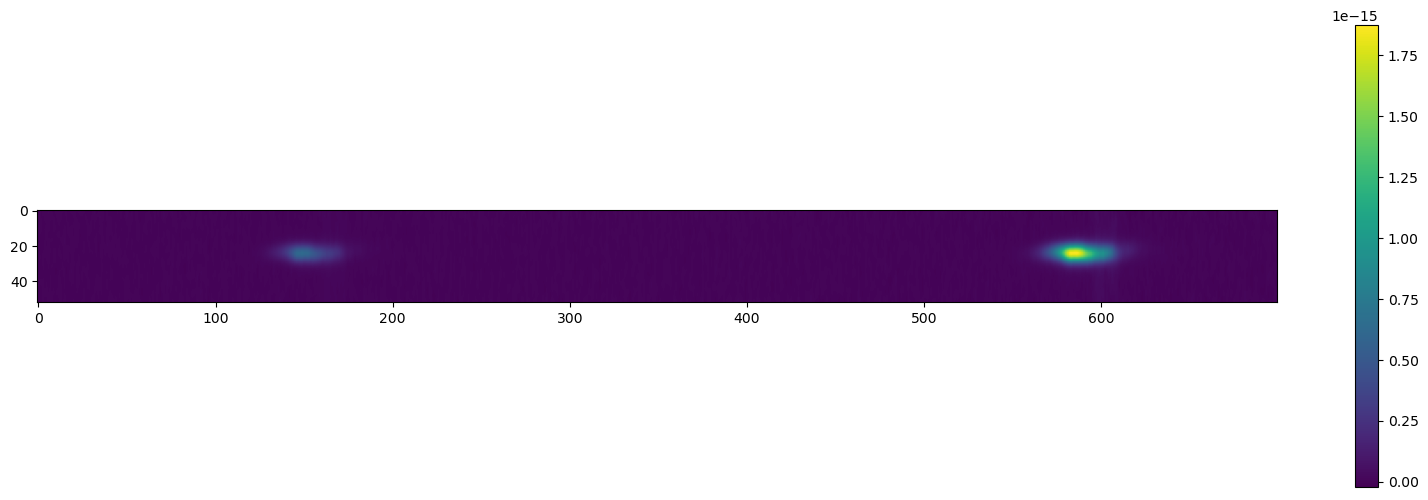

In [27]:

fig = plt.figure(figsize=(20,6))
plt.imshow(data.unmasked_data[3400:-200,:,25].T.to_value(), )
plt.colorbar();

In [7]:
from spectral_cube import SpectralCube
import numpy as np
from visl3d import misc
from scipy.stats import norm
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

# Read the fits file and save header
data = SpectralCube.read("../../flux_HRR_final_rss.fits")
cubehead = data.header
nz, ny, nx = data.shape
print(data.shape)
dra, ddec, dv = cubehead['CDELT1'], cubehead['CDELT2'], cubehead['CDELT3']
units = [cubehead['BUNIT'], cubehead['CUNIT1'], cubehead['CUNIT2'], cubehead['CUNIT3']]
mags = ["Intensity", cubehead['CTYPE1'], cubehead['CTYPE2'], cubehead['CTYPE3']]
delta = (np.abs(dra), np.abs(ddec), np.abs(dv))
print(delta)

# Limits to crop the cube, no HI there. Subtract 1 to wanted number, e.g. nz-1.
limx = [0, nx-1]
limy = [0, ny-1]
limz = [0, nz-1]

# Calculate coordinates from limits
ralim = data.spatial_coordinate_map[1][0,:][limx][::int(np.sign(cubehead["CDELT1"]))]
ramean = np.mean(ralim)
declim = data.spatial_coordinate_map[0][:,0][limy][::int(np.sign(cubehead["CDELT2"]))]
decmean = np.mean(declim)
vlim = data.spectral_axis[limz][::int(np.sign(dv))]
vmean = np.mean(vlim).to_value()

coords = np.array([ralim, declim, vlim])
print(coords)

(4300, 52, 58)
(5.9531227756441e-05, 5.9555555555555e-05, 0.09739999999999999)
[[2.15470951e-02 2.49404672e-02]
 [4.22059556e-01 4.25096889e-01]
 [6.39009740e+03 6.80882000e+03]]


In [4]:
spectral_lims = [[6542.00*u.angstrom,6552.00*u.angstrom],
                 [6557.05*u.angstrom,6567.05*u.angstrom],
                 [6572.45*u.angstrom,6588.45*u.angstrom]]

isolevels_p = [20,35,50,65,80]
isolevels = [isolevels_p, isolevels_p, isolevels_p]
a58_hrr = vis.prep_mult("../../flux_HRR_final_rss_corr.fits", spectral_lims=spectral_lims, unit='percent',
                        l_isolevels=isolevels, lines=['NII_1', 'Halpha', 'NII_2'])

aaaa


In [5]:
ncu.coords

array([[ 131.71604324,  131.72276546],
       [  17.87639685,   17.88239685],
       [4567.89      , 5040.89      ]])

In [10]:
from visl3d import visual as vis
import astropy.units as u


lims = [[131.71604324*u.deg, 131.72276546*u.deg],
        [17.87639685*u.deg, 17.88239685*u.deg],
        [5000*u.Angstrom, 5012*u.Angstrom]]

ncu = vis.prep_one("D:\hypercube_mrb_a30.fits", unit='percent', lims=lims, isolevels=[2,5,10,15], image2d='DSS2 Blue')

vis.createX3D(ncu, 'test_a30.x3d')
vis.createHTML(ncu, 'test_a30.html')


If the path leads to a local server, the visualisation can be accessed in a web browser with "localhost/path/from/DocumentRoot/test_a30.html"


In [1]:
from spectral_cube import SpectralCube
import numpy as np
from visl3d import visual as vis
import astropy.units as u
mask1 = SpectralCube.read('C:\\Users\\ixaka\\Documents\\Optical-Montoro\\flux_HRR_final_rss-mask.fits')
mask1.shape

(4300, 52, 58)

In [2]:
data1 = SpectralCube.read("../../flux_HRR_final_rss_corr.fits")
head1 = data1.header

In [3]:
data1 = data1.unmasked_data[:] * mask1.unmasked_data[:]/np.max(mask1.unmasked_data[:])
data1.shape

# limx = [0, 58-1]
# limy = [0, 52-1]
# limz = [1520, 2100-1]

spectral_lims = [[6542.00*u.angstrom,6552.00*u.angstrom],
                 [6557.05*u.angstrom,6567.05*u.angstrom],
                 [6572.45*u.angstrom,6588.45*u.angstrom]]

isolevels_p = [20,35,50,65,80]
isolevels = [isolevels_p, isolevels_p, isolevels_p]

a58_hrr = vis.prep_mult(data1, header=head1, spectral_lims=spectral_lims, unit='percent',
                        l_isolevels=isolevels, lines=['NII_1', 'Halpha', 'NII_2'])
vis.createX3D(a58_hrr, 'a58_hrr.x3d')
vis.createHTML(a58_hrr, 'a58_hrr.html')

If the path leads to a local server, the visualisation can be accessed in a web browser with "localhost/path/from/DocumentRoot/a58_hrr.html"


In [3]:
from spectral_cube import SpectralCube
mask2 = SpectralCube.read('C:\\Users\\ixaka\\Documents\\Optical-Montoro\\flux_MRB_final_rss_subCube-mask_copy.fits')
mask2.shape

(682, 52, 58)

In [4]:
data2 = SpectralCube.read("../../flux_MRB_final_rss_subCube.fits") # OIII
head2 = data2.header
data2.shape

(682, 52, 58)

In [5]:
from visl3d import misc

oiii = 5006.843 #OIII 1
oiii = misc.find_nearest(data2.spectral_axis, oiii)
nii = 6583.45 #NII 2
nii = misc.find_nearest(data1.spectral_axis, nii)
ha = 6562.05 #Halpha
ha = misc.find_nearest(data1.spectral_axis, ha)

In [6]:
coords = [[data1.spatial_coordinate_map[1][0,:][0].value, data1.spatial_coordinate_map[1][0,:][-1].value],
          [data1.spatial_coordinate_map[0][:,0][0].value, data1.spatial_coordinate_map[0][:,0][-1].value],
          [data1.spectral_axis[0].value, data1.spectral_axis[-1].value]]
coords = np.sort(coords)
print('COORDS = ',coords)
delta = np.array([np.mean([head1['CDELT1'], head2['CDELT1']]),
                  np.mean([head1['CDELT2'], head2['CDELT2']]),
                  np.mean([head1['CDELT3'], head2['CDELT3']])])
print('DELTA = ',delta)

COORDS =  [[2.15470951e-02 2.49404672e-02]
 [4.22059556e-01 4.25096889e-01]
 [6.39009740e+03 6.80882000e+03]]
DELTA =  [-5.95312278e-05  5.95555556e-05  1.03700000e-01]


In [7]:
data1 = data1.unmasked_data[:] * mask1.unmasked_data[:]/np.max(mask1.unmasked_data[:])
data1.shape

(4300, 52, 58)

In [8]:
data2 = data2.unmasked_data[:] * mask2.unmasked_data[:]/np.max(mask2.unmasked_data[:])
data2.shape

(682, 52, 58)

In [9]:
hw = 50

data_oiii = data2[oiii[1]-hw:oiii[1]+hw].to_value()
data_nii = data1[nii[1]-hw:nii[1]+hw].to_value()
data_ha = data1[ha[1]-hw:ha[1]+hw].to_value()
data_oiii.shape, data_nii.shape, data_ha.shape

((100, 52, 58), (100, 52, 58), (100, 52, 58))

In [10]:
data_oiii = data_oiii/np.max(data_oiii) * 100
data_nii = data_nii/np.max(data_nii) * 100
data_ha = data_ha/np.max(data_ha) * 100

In [11]:
# # because the mask is for the full cube and we upload only the subcube, we need to cut the mask
import numpy as np
minl = np.where(np.abs(mask2.spectral_axis-6542*u.angstrom) == np.min(np.abs(mask2.spectral_axis-6542*u.angstrom)))[0][0]
maxl = np.where(np.abs(mask2.spectral_axis-6588.45*u.angstrom) == np.min(np.abs(mask2.spectral_axis-6588.45*u.angstrom)))[0][0]
mask2 = mask2.unmasked_data[minl:maxl+1]

In [12]:
data_oiii = misc.transpose(data_oiii, (head2['CDELT1'], head2['CDELT2'], head2['CDELT3']))
data_nii = misc.transpose(data_nii, delta)
data_ha = misc.transpose(data_ha, delta)

In [14]:
data = [data_oiii, data_nii, data_ha]
isolevels_p = [20,35,50,65,80]
isolevels = [isolevels_p, isolevels_p, isolevels_p]
mags=['Intensity', 'RA', 'DEC', 'WAVELENGTH']
# l_colors = [misc.create_colormap('Blues', isolevels[0], start=70), misc.create_colormap('Reds', isolevels[1], start=70),
#             misc.create_colormap('Greens', isolevels[2], start=70)]

shifts = np.array([[0,0,0],[0.8895*delta[0], 1.8222*delta[1], 0],[0.8895*delta[0], 1.8222*delta[1], 0]])
shifts = np.array([[0,0,0],[-0.8895, 1.8222, 0],[-0.8895, 1.8222, 0]])

a58_over = vis.Cube(l_cubes=data, name='3D Interactive Visualisation: A58_1.1', coords=coords,
                    l_isolevels=isolevels, cmaps=['Blues', 'Reds', 'Greens'],
                    units=['%', 'deg', 'deg', 'Angstrom'], mags=mags, delta=delta,
                    lines=['OIII', 'NII', 'Halpha'])

In [15]:
vis.createX3D(a58_over, 'a58_overlay.x3d', shifts=shifts)
vis.createHTML(a58_over, 'a58_overlay.html')

[[23.969    22.       42.      ]
 [24.       22.       41.878166]
 [24.       21.940214 42.      ]
 ...
 [35.203175 26.       51.      ]
 [35.097267 26.       52.      ]
 [35.003574 26.       53.      ]]
[0. 0. 0.]
[[24.99752  22.       45.      ]
 [25.       22.       44.966175]
 [25.       21.99561  45.      ]
 ...
 [34.02067  26.       47.      ]
 [34.032    26.       48.      ]
 [34.00616  26.       49.      ]]
[0. 0. 0.]
[[25.981237 22.       47.      ]
 [26.       22.       46.70323 ]
 [26.       21.971142 47.      ]
 ...
 [33.036144 26.       47.      ]
 [33.05068  26.       48.      ]
 [33.00915  26.       49.      ]]
[0. 0. 0.]
[[26.954887 23.       42.      ]
 [27.       23.       41.865448]
 [27.       22.92596  42.      ]
 ...
 [32.068783 26.       47.      ]
 [32.092007 26.       48.      ]
 [32.025433 26.       49.      ]]
[0. 0. 0.]
[[27.801165 23.       43.      ]
 [28.       23.       42.556717]
 [28.       22.783419 43.      ]
 [28.       22.494467 44.      ]
 [27.555

In [10]:
# limx = [0, 58-1]
# limy = [0, 52-1]
# limz = [1520, 2100-1]

spectral_lims = [[6542.00*u.angstrom,6552.00*u.angstrom],
                 [6557.05*u.angstrom,6567.05*u.angstrom],
                 [6572.45*u.angstrom,6588.45*u.angstrom]]

isolevels_p = [20,35,50,65,80]
isolevels = [isolevels_p, isolevels_p, isolevels_p]

data = [data_oiii, data_nii, data_ha]

a58_over = vis.prep_overlay(data, header=head2, unit='percent',
                        l_isolevels=isolevels, lines=['OIII', 'Halpha', 'NII'])
vis.createX3D(a58_over, 'a58_overlay.x3d')
vis.createHTML(a58_over, 'a58_overlay.html')

AttributeError: 'list' object has no attribute 'values'